In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('datasets/Credit.csv')
df['Credit'].value_counts()

0    7509
1     517
Name: Credit, dtype: int64

In [4]:
x = df.iloc[:,1:]
y = df['Credit']

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
x_train,x_test,y_train,y_test = train_test_split(x,y,stratify=y,random_state=42)

In [7]:
from sklearn.preprocessing import StandardScaler

In [8]:
st = StandardScaler()
x_train_std = st.fit_transform(x_train)
x_test_std = st.fit_transform(x_test)

In [9]:
x_train_std.shape

(6019, 10)

In [10]:
# Build model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from livelossplot import PlotLossesKerasTF

2023-03-11 07:43:51.039908: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


KeyboardInterrupt: 

In [ ]:
# Build Autoencoder
input_data = Input(shape=(10,))
encoded_1 = Dense(8,activation='relu')(input_data)
encoded_2 = Dense(5,activation='relu')(encoded_1)
decoded_1 = Dense(8,activation='relu')(encoded_2)
decoded_2 = Dense(10,activation='relu')(decoded_1)

2023-03-05 09:45:30.122768: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
ae = Model(input_data, decoded_2)

In [ ]:
encoder = Model(input_data, encoded_2)

In [ ]:
ae.compile(
    loss='mse',
    metrics='mae',
    optimizer='adam'
)

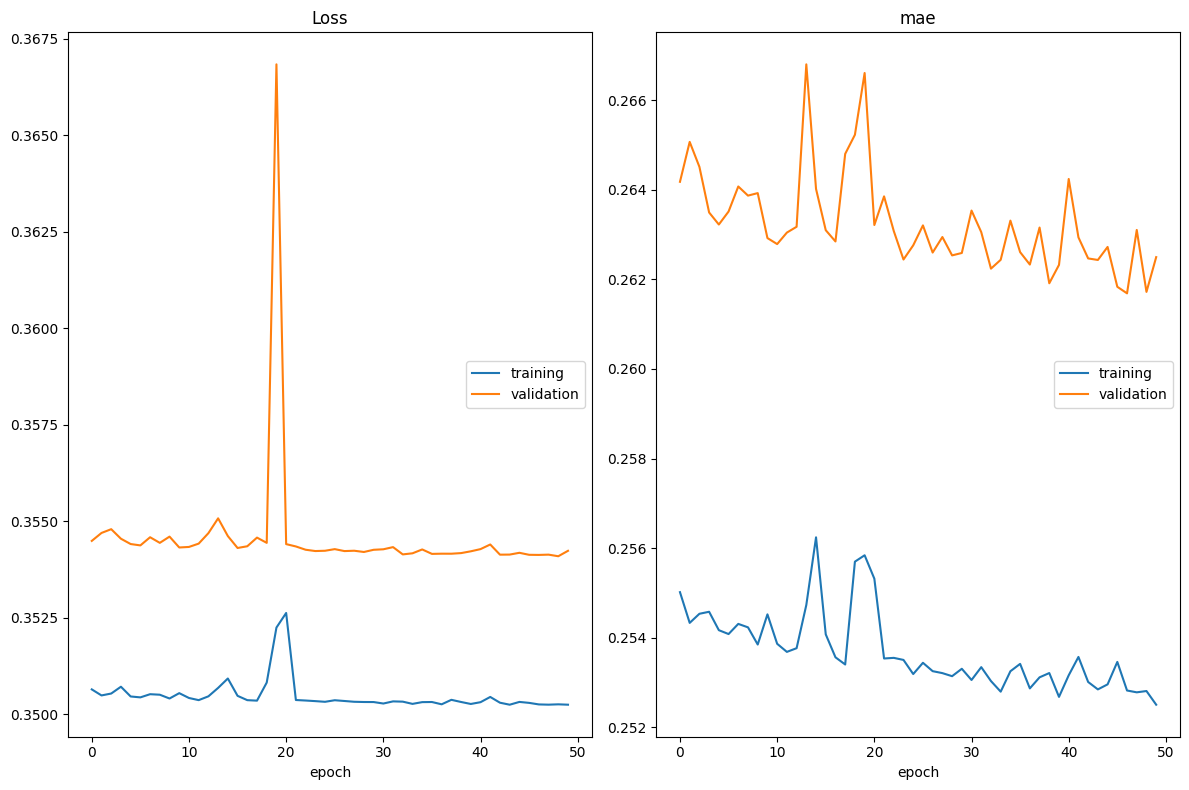

Loss
	training         	 (min:    0.350, max:    0.353, cur:    0.350)
	validation       	 (min:    0.354, max:    0.367, cur:    0.354)
mae
	training         	 (min:    0.253, max:    0.256, cur:    0.253)
	validation       	 (min:    0.262, max:    0.267, cur:    0.262)
48/48 [==============================] - 1s 11ms/step - loss: 0.3503 - mae: 0.2525 - val_loss: 0.3542 - val_mae: 0.2625


In [ ]:
ae.fit(
    x_train_std,
    x_train_std,  # input == output for autoencoders
    epochs=50,
    batch_size=128,
    validation_data=(x_test_std, x_test_std),
    callbacks=[PlotLossesKerasTF()]
)

In [ ]:
x_train_reconstructed = ae.predict(x_train_std)

189/189 [==============================] - 1s 1ms/step


In [ ]:
x_test_reconstructed = ae.predict(x_test_std)

63/63 [==============================] - 0s 988us/step


# Plot observations to expose anomalies

In [ ]:
import numpy as np

In [ ]:
# get MSE on train data
reconstructed_error_train = np.mean(np.power(x_train_std-x_train_reconstructed,2),axis=1)

In [ ]:
reconstructed_error_train

array([0.07174936, 0.06444467, 0.09868033, ..., 0.36151324, 0.0890542 ,
       0.19119323])

In [ ]:
# map against the actual value of whether credit was extended or not
error_df_train = pd.DataFrame({
    'Error': reconstructed_error_train,
    'TrainLabels': y_train
})

In [ ]:
error_df_train

,Error,TrainLabels
4835,0.071749,0
7415,0.064445,0
2403,0.098680,0
7553,0.085106,0
3169,0.179274,0
...,...,...
3829,0.164797,0
7314,0.202552,0
4623,0.361513,0
4534,0.089054,0


In [ ]:
# plot to show anomalies more broadly
from matplotlib import pyplot as plt
import seaborn as sns

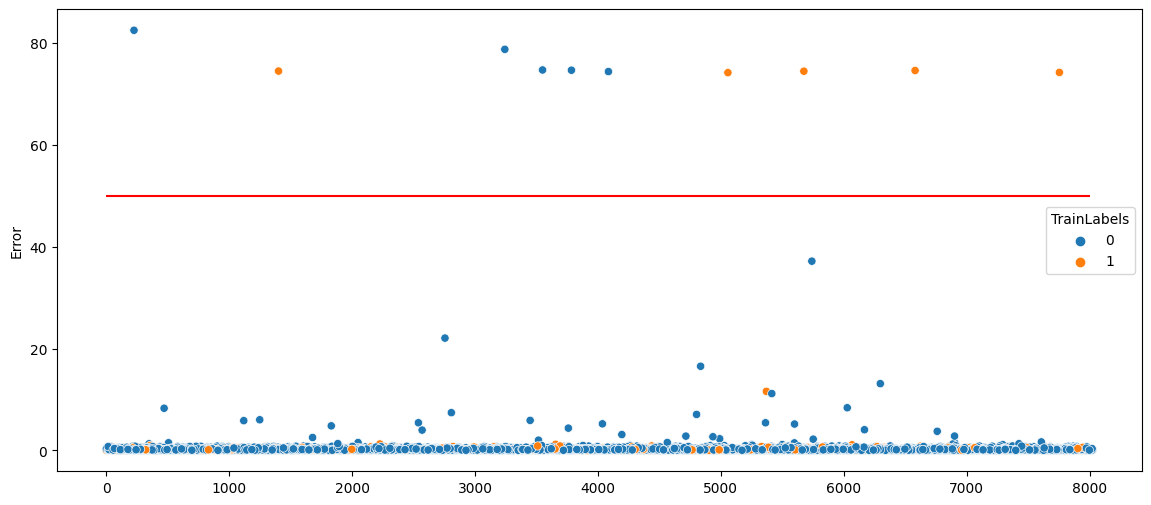

In [ ]:
plt.figure(figsize=(14,6))
sns.scatterplot(
    data=error_df_train,
    x=error_df_train.index,
    y='Error',
    hue='TrainLabels'
)
plt.hlines(50,0,8000,color='red') # show anomaly threshold line of 50 for the error value
plt.show()

In [ ]:
# Identify anomalies in a DF
pd.crosstab(
    error_df_train['TrainLabels'],
    error_df_train.Error>50
)

Error,False,True
TrainLabels,,
0,5626,5
1,383,5


In [ ]:
# Build a new model to try to reduce anomalies
from tensorflow.keras.layers import Dropout  # to reduce overfitting

In [ ]:
input_data = Input(shape=(10,))
encoded_1 = Dense(16,activation='relu')(input_data)
encoded_2 = Dense(32,activation='relu')(encoded_1)
decoded_1 = Dense(16,activation='relu')(encoded_2)
decoded_2 = Dense(10,activation='relu')(decoded_1)

ae = Model(input_data, decoded_2)

encoder = Model(input_data, encoded_2)



In [ ]:
ae.compile(
    loss='mse',
    metrics='mae',
    optimizer='adam'
)

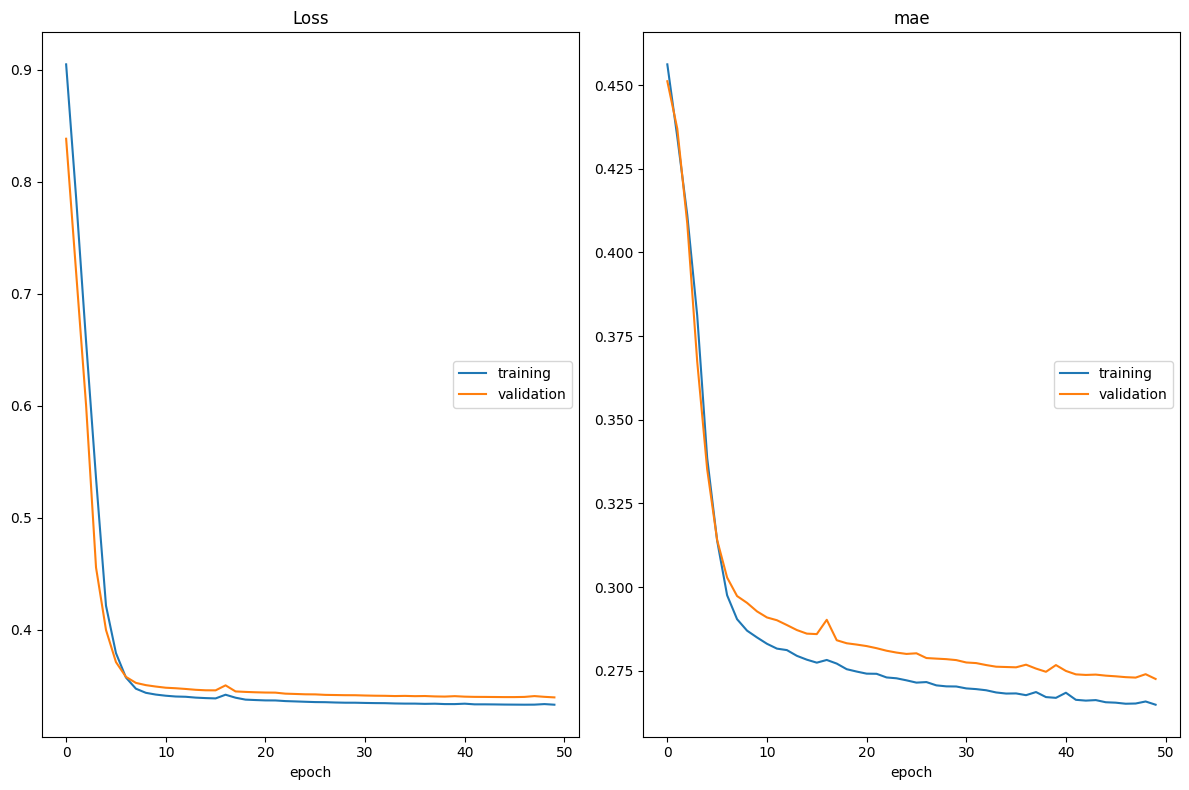

Loss
	training         	 (min:    0.333, max:    0.905, cur:    0.333)
	validation       	 (min:    0.340, max:    0.838, cur:    0.340)
mae
	training         	 (min:    0.265, max:    0.456, cur:    0.265)
	validation       	 (min:    0.273, max:    0.451, cur:    0.273)
48/48 [==============================] - 1s 11ms/step - loss: 0.3330 - mae: 0.2648 - val_loss: 0.3396 - val_mae: 0.2725


In [ ]:
ae.fit(
    x_train_std,
    x_train_std,  # input == output for autoencoders
    epochs=50,
    batch_size=128,
    validation_data=(x_test_std, x_test_std),
    callbacks=[PlotLossesKerasTF()]
)

NameError: name 'x_train_std' is not defined